## CalMS21 multiple trials using 5 states 

In [1]:
from bbvi_infer_2lB import * 
from calms import *
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read in data observations

In [2]:
input_name = '/data/calms_task1/calms21_task1_train.json'
with open(input_name, 'r') as fp:
    input_data = json.load(fp)
data = convert_to_array(input_data)

In [3]:
## Observations
scaler, trials = fit_scaler(data, [34, 50])

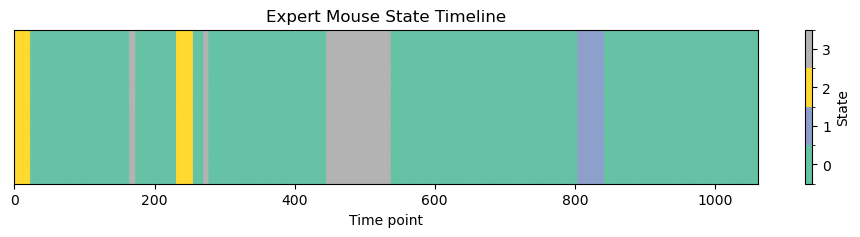

In [4]:
## States 
states = data['annotator-id_0']['task1/train/mouse034_task1_annotator1']['annotations']
plot_expert(states)

In [5]:
K=5 ## state
D=3 ## latent dimension

## GSD
### GSD Train

In [6]:
trials[0].shape,trials[1].shape

(torch.Size([1062, 28]), torch.Size([1283, 28]))

  0%|          | 0/4000 [00:00<?, ?it/s]

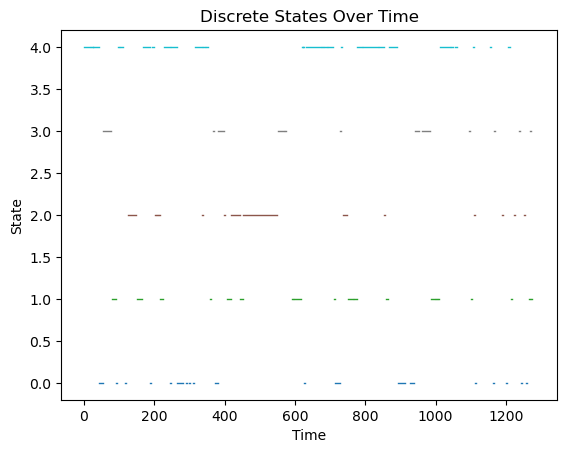

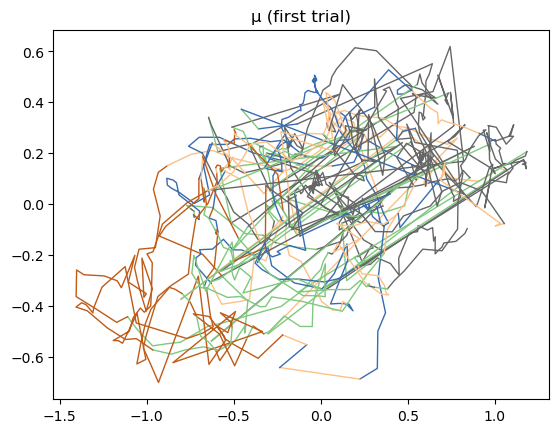

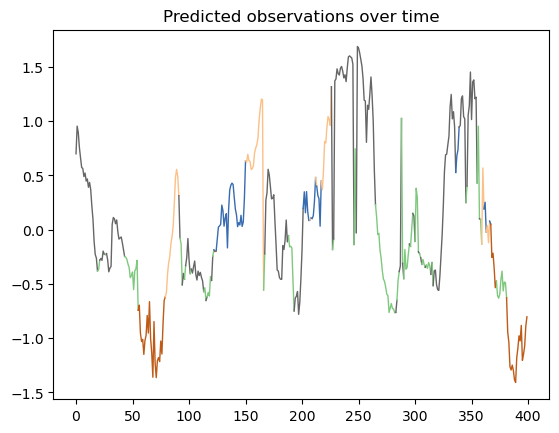

/root/capsule/code/CalMS/bbvi_infer_2lB.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("R2:", train_metrics(torch.tensor(ys_first), y_preds0.mean(dim=0).cpu()))
ELBO: -61980.1, LR: 0.01000, Tau: 0.990:   0%|          | 10/4000 [00:01<05:28, 12.16it/s] 

R2: [-0.49237778782844543]


ELBO: -18398.9, LR: 0.01000, Tau: 0.990:   5%|▍         | 199/4000 [00:03<00:44, 85.32it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: -18272.5, LR: 0.01000, Tau: 0.990:   5%|▍         | 199/4000 [00:03<00:44, 85.32it/s]

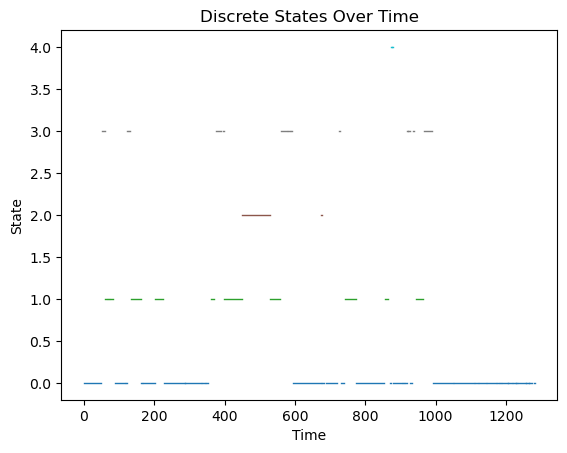

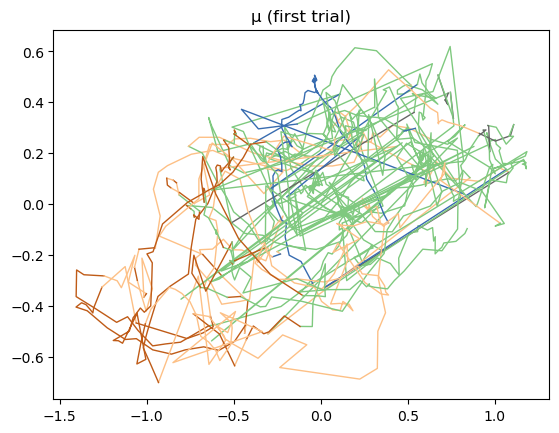

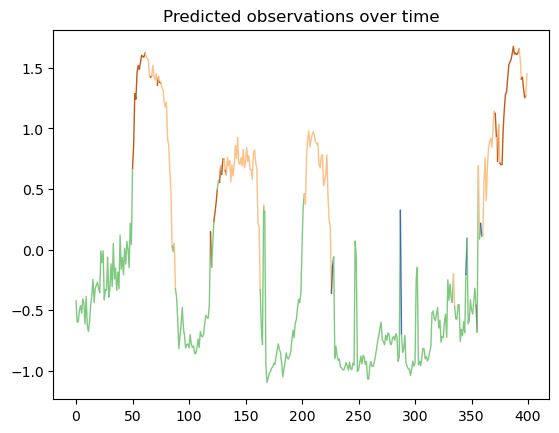

ELBO: -17637.9, LR: 0.00962, Tau: 0.990:   5%|▌         | 217/4000 [00:04<01:37, 38.67it/s]

R2: [0.8074512481689453]


ELBO: -15117.2, LR: 0.00550, Tau: 0.990:  10%|▉         | 397/4000 [00:06<00:42, 84.07it/s]

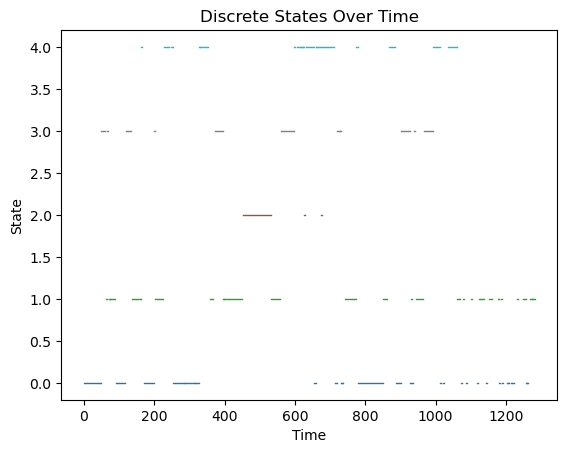

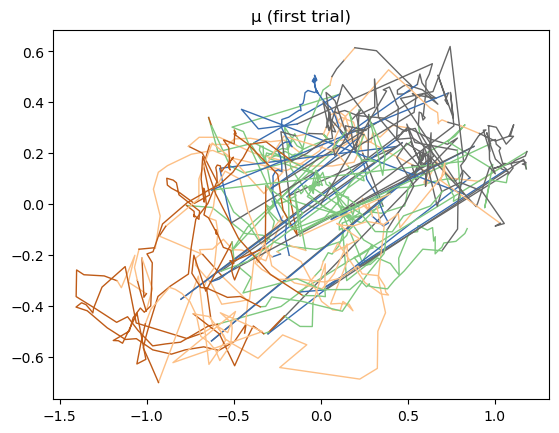

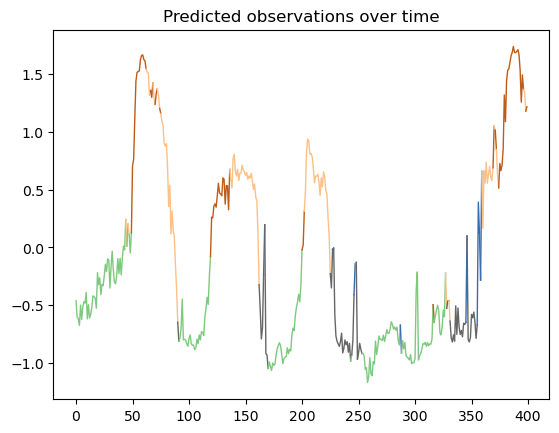

ELBO: -15002.2, LR: 0.00512, Tau: 0.990:  10%|█         | 415/4000 [00:07<01:49, 32.85it/s]

R2: [0.8456873893737793]


ELBO: -15080.9, LR: 0.00341, Tau: 0.990:  12%|█▏        | 492/4000 [00:08<00:58, 59.99it/s]


Early stopping at iteration 492.


In [7]:
model = GenerativeSLDS(N=28, K=K, D=D, emission_model="gaussian")
elbos, variational_z = fit_bbvi_schedule(model.to('cuda'), trials= trials, 
                                         num_iters=4000, learning=True, n_samples=10, base_lr=1e-2, 
                                         warmup_iters=200, tau_max=0.99, verbose=True)

Text(0, 0.5, 'ELBO')

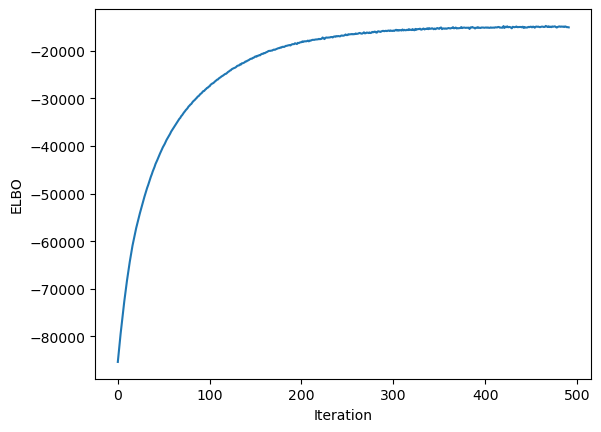

In [8]:
plt.figure()
plt.plot(elbos[1:])
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [9]:
device = next(model.parameters()).device
# Convert list of trials to a single padded tensor
ys_train_tensor = pad_collate([trials[0]])[0].to(device).float()  # [B, T_max, N]

# Sample latent states
zs = variational_z.sample_q_z(
    ys_train_tensor.unsqueeze(0).expand(20, -1, -1, -1),temperature=0.99)
# Smoothed prediction
pred_ys0 = model.smooth(ys_train_tensor, zs).mean(dim=0).detach().cpu().numpy()  # [B,T,N]

# k-step predictions
y_preds, z_preds = predict_k_step_more(
    k_max=10, model=model, variational_z=variational_z, ys=ys_train_tensor)
# Compute R2
print("Train accuracy:", train_metrics(ys_train_tensor, pred_ys0, y_preds, k_max=10))

Train accuracy: [0.8538094162940979, 0.632292628288269, 0.6295328140258789, 0.6064342260360718, 0.580339252948761, 0.5515299439430237, 0.5214115977287292, 0.4879460036754608, 0.45275554060935974, 0.4182668626308441, 0.3855678141117096]


### GSD Test

In [11]:
device = next(model.parameters()).device
# Convert list of trials to a single padded tensor
ys_test_tensor = pad_collate([trials[1]])[0].to(device).float()  # [B, T_max, N]

# Sample latent states
zs2 = variational_z.sample_q_z(
    ys_test_tensor.unsqueeze(0).expand(20, -1, -1, -1),temperature=0.99)
# Smoothed prediction
pred_ys0 = model.smooth(ys_test_tensor, zs2).mean(dim=0).detach().cpu().numpy()  # [B,T,N]

# k-step predictions
y_preds, z_preds = predict_k_step_more(
    k_max=10, model=model, variational_z=variational_z, ys=ys_test_tensor)
# Compute R2
print("Train accuracy:", train_metrics(ys_test_tensor, pred_ys0, y_preds, k_max=10))

Train accuracy: [0.9247952699661255, 0.8183868527412415, 0.8136997222900391, 0.7943578362464905, 0.7733659148216248, 0.7493450045585632, 0.7234500050544739, 0.695611834526062, 0.6664652824401855, 0.6359016299247742, 0.6042799949645996]


In [13]:
### State quality
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
Z_train = torch.mean(zs, dim=0)[0].detach().cpu().numpy()
Y_train = data['annotator-id_0']['task1/train/mouse034_task1_annotator1']['annotations']
Z_test = torch.mean(zs2, dim=0)[0].detach().cpu().numpy()
Y_test = data['annotator-id_0']['task1/train/mouse050_task1_annotator1']['annotations']
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
acc1 = knn.score(Z_train, Y_train)
acc = knn.score(Z_test, Y_test)
print("Test accuracy:", acc)
print("Train accuracy:", acc1)

Test accuracy: 0.7731878409976617
Train accuracy: 0.908662900188324


We are ready to train the model on multiple trials within CalMS training dataset, and apply to CalMS testing dataset for state quality of all trials in the testing dataset.  